# Nicholas Stafford
### May 23, 2024

## Scraping, Cleaning, and Merging Data

In [ ]:
from pathlib import Path, PureWindowsPath
import os

import time
from time import sleep
import selenium
from selenium import webdriver

from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
chrome_options = Options()

import requests
from bs4 import BeautifulSoup as bs

import numpy as np
import pandas as pd

from datetime import date
from geopy.geocoders import Nominatim as nom
from geopy import distance

In [ ]:
## Selenium scroll and click for more observations
#----------------------------------------------------#

driver = webdriver.Chrome()
chrome_options.add_argument("--window-size=1920,1080")
driver = webdriver.Chrome(options = chrome_options)


driver.implicitly_wait(20)
time.sleep(2)

gas_url = "https://www.carfuel.unleaded.com"
driver.get(gas_url)

# scrolls by inputted number of pixels given ads
driver.execute_script("window.scrollBy(0, ####)")
driver.find_element(By.XPATH, '//*[@id="root"]/tag/tag/tag').click()
driver.implicitly_wait(5)
time.sleep(3)
    
count = 0
while count < number_of_buttons_to_click_after_initial:
    # scrolls by inputted number of pixels after the ads are passed
    driver.execute_script("window.scrollBy(0, ####)")
    driver.find_element(By.XPATH, '//*[@id="root"]/tag/tag/tag').click()
    driver.implicitly_wait(5)
    time.sleep(3)
    count += 1
    
page = driver.page_source

In [ ]:
## Providing beautiful soup with html to scrape
#-------------------------------------------------#

seleniumsoup = bs(page)
seleniumsoup

In [ ]:
## Using beautiful soup to pick out the data needed
#-----------------------------------------------------#

out = []

# Finds all info blocks that contain names, prices, addresses, etc.
station = seleniumsoup.find_all('tag', {'attribute': 'station_info_block'})

# For each info block, find and append the name, price, street, and city
for i in range(0, len(station)):
    name = station[i].find('tag', {'attribute': 'font:calibri;'}).text
        
    price = station[i].find('tag',{'attribute':'station_price'}).text

    street = str(station[i].find('tag', {'attribute': 'station_address'})).split('1st_tag')[1].split('2nd_tag')[0]
    city = str(station[i].find('tag', {'attribute': 'station_address'})).split('2nd_tag')[1].split('3rd_tag')[0]
    
    # Variables append here
    data = {'name': name, 'price': price, 'street': street, 'city': city, 'merge_control': 1}
    out.append(data)

station_data = pd.DataFrame(out)

station_data = station_data.replace('Unknown price', np.nan)
station_data['price'] = pd.to_numeric(station_data['price'])
print(type(station_data['price'][0]))
station_data

In [ ]:
## Using beautiful soup to grab WTI prices from a second website
#------------------------------------------------------------------#

headers = {
    'User-Agent': 'University Student'
}

wti_url = "https://www.wtiprice.com"
response2 = requests.get(wti_url, headers=headers)
soup2 = bs(response2.text, 'html.parser')

crude = []
wti = soup2.find('tag', {'attribute': 'wti_number'}).text

data2 = {'merge_control': 1, 'wti': wti, 'date': date.today()}
crude.append(data2)

crude = pd.DataFrame(crude)
crude

In [ ]:
## Merging data from both sites
#---------------------------------#

df = pd.merge(station_data, crude, left_on=['merge_control'], right_on=['merge_control'], how='left')
df

In [ ]:
## Changing street names to be intelligible by geocoding api
#--------------------------------------------------------------#

df.loc[df['street'] == '400 That One St', 'street'] = '400 That One Dr'
                 ### 400 That One St, City, State --> 400 That One Dr, City, State
    
# Repeat above step as necessary to adjust the incorrectly listed addresses
# on the site to the addresses that actually belong to the station in the api

df['full_address'] = df['street'] + ', ' + df['city']
df = df.dropna()
df = df.reset_index(drop = True)

In [ ]:
## Using nominatim package to translate addresses to latitudes and longitudes
#-------------------------------------------------------------------------------#

geolocator = nom(user_agent="Student")
spot = []
address_list = list(df['full_address'])
address_count = 0


for m in range(0,len(address_list)):
    location = geolocator.geocode(address_list[m])
    spot.append((location.latitude, location.longitude))
    time.sleep(.5)
    address_count += 1
    if address_count % 10 == 0:
        print(address_count)
    
print('Locations collected')

In [ ]:
## Collecting the Latitudes and longitudes for each station
#-------------------------------------------------------------#

lat = []
long = []
lat_inner = []
long_inner = []
for k in spot:
    lat_inner, long_inner = k
    lat.append(lat_inner)
    long.append(long_inner)

df['lat'] = lat
df['long'] = long

In [ ]:
## Using distance package to translate lats and longs to distances for firm density variable
#---------------------------------------------------------------------------------------------#

num_radius = []

# For each station, find the distance to every gas station
# and count the number of stations within a half mile
for n in range(0,len(spot)):
    station_1 = spot[n]
    c = 0
    
    for o in range(0,len(spot)):
        station_2 = spot[o]
        radius = distance.distance(station_1, station_2).miles
        if radius <= .5:
            c += 1
            
    num_radius.append(c-1)
        # "c-1" accounts for the station being close to itself in the calculation

df['num_radius'] = num_radius
df

In [ ]:
## An additional variable may be the distance from each station to the closest other station
#----------------------------------------------------------------------------------------------#

closest = []

for n in range(0,len(spot)):
    station_1 = spot[n]
    radius = []
    
    for o in range(0,len(spot)):
        if o != n:
            station_2 = spot[o]
            radius.append(distance.distance(station_1, station_2).miles)
            
    closest.append(min(radius)) 

df['closest'] = closest
df

# Note, after you collect the variables in the above steps, you can simply create a new
# csv file with just the full_addresses and their corresponding num_radius, closest, lat, 
# and long values then merge the collected data with the new csv to apply the variables
# as such:
        # distances_df = pd.read_csv('distances.csv')
        # df = pd.merge(df, distances_df, how='left')

In [ ]:
## Adding new daily observations to existing csv
#--------------------------------------------------#

# If first collection, skip this chunk

df2 = pd.read_csv('stafford_gas_prices.csv')
df3 = pd.concat([df2,df])
df3

In [ ]:
## Saving csv and closing driver
#----------------------------------#

# If first collection, use following two lines
#df.to_csv('stafford_gas_prices.csv', index=False)
#driver.quit()

df3.to_csv('stafford_gas_prices.csv', index=False)
driver.quit()

## Data Visualizations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Calculating the average prices in the area by day
#------------------------------------------------------#

df = pd.read_csv('stafford_gas_prices.csv')

avg_price_date = df[['date','price','wti']].groupby('date').mean().reset_index().rename({'price':'avg_price'}, axis = 1)
avg_price_date

In [ ]:
## Making a two-plot figure for average prices and the wti for each day
#-------------------------------------------------------------------------#

# Structure of the figure (one plot above the other)
fig, ax = plt.subplots(nrows = 2, ncols = 1)

# First and top plot
ax2 = plt.subplot(2, 1, 1)
ax2.plot(avg_price_date['date'], avg_price_date['wti'], color = '#ff70be')
ax2.set_xticks(np.arange(len(avg_price_date['Date'])), ['day', 'day', 'day', 'day', 'etc'], rotation = 45, ha ='right')
ax2.set_xlabel('Date')             # note above, the arange in set_xticks steps by each day unless specified otherwise
ax2.set_ylabel('Oil $/Barrel')

# Second and bottom plot
ax1 = plt.subplot(2, 1, 2)
ax1.plot(avg_price_date['date'], avg_price_date['avg_price'], color = '#5ff0ac')
ax1.set_xticks(np.arange(len(avg_price_date['Date'])), ['day', 'day', 'day', 'day', 'etc'], rotation = 45, ha ='right')
ax1.set_xlabel('Date')
ax1.set_ylabel('Gas $/Gallon')

# Titles
fig.suptitle('Price of Gas', fontsize = 15, position = (.53,.95))
ax1.set_title('Average Price in "Area"')
ax2.set_title('Price per Barrel Internationally')

# Saving  and showing the figure
fig.tight_layout()
plt.savefig('priceofgas.png', dpi = 300, transparent=False)
plt.show()

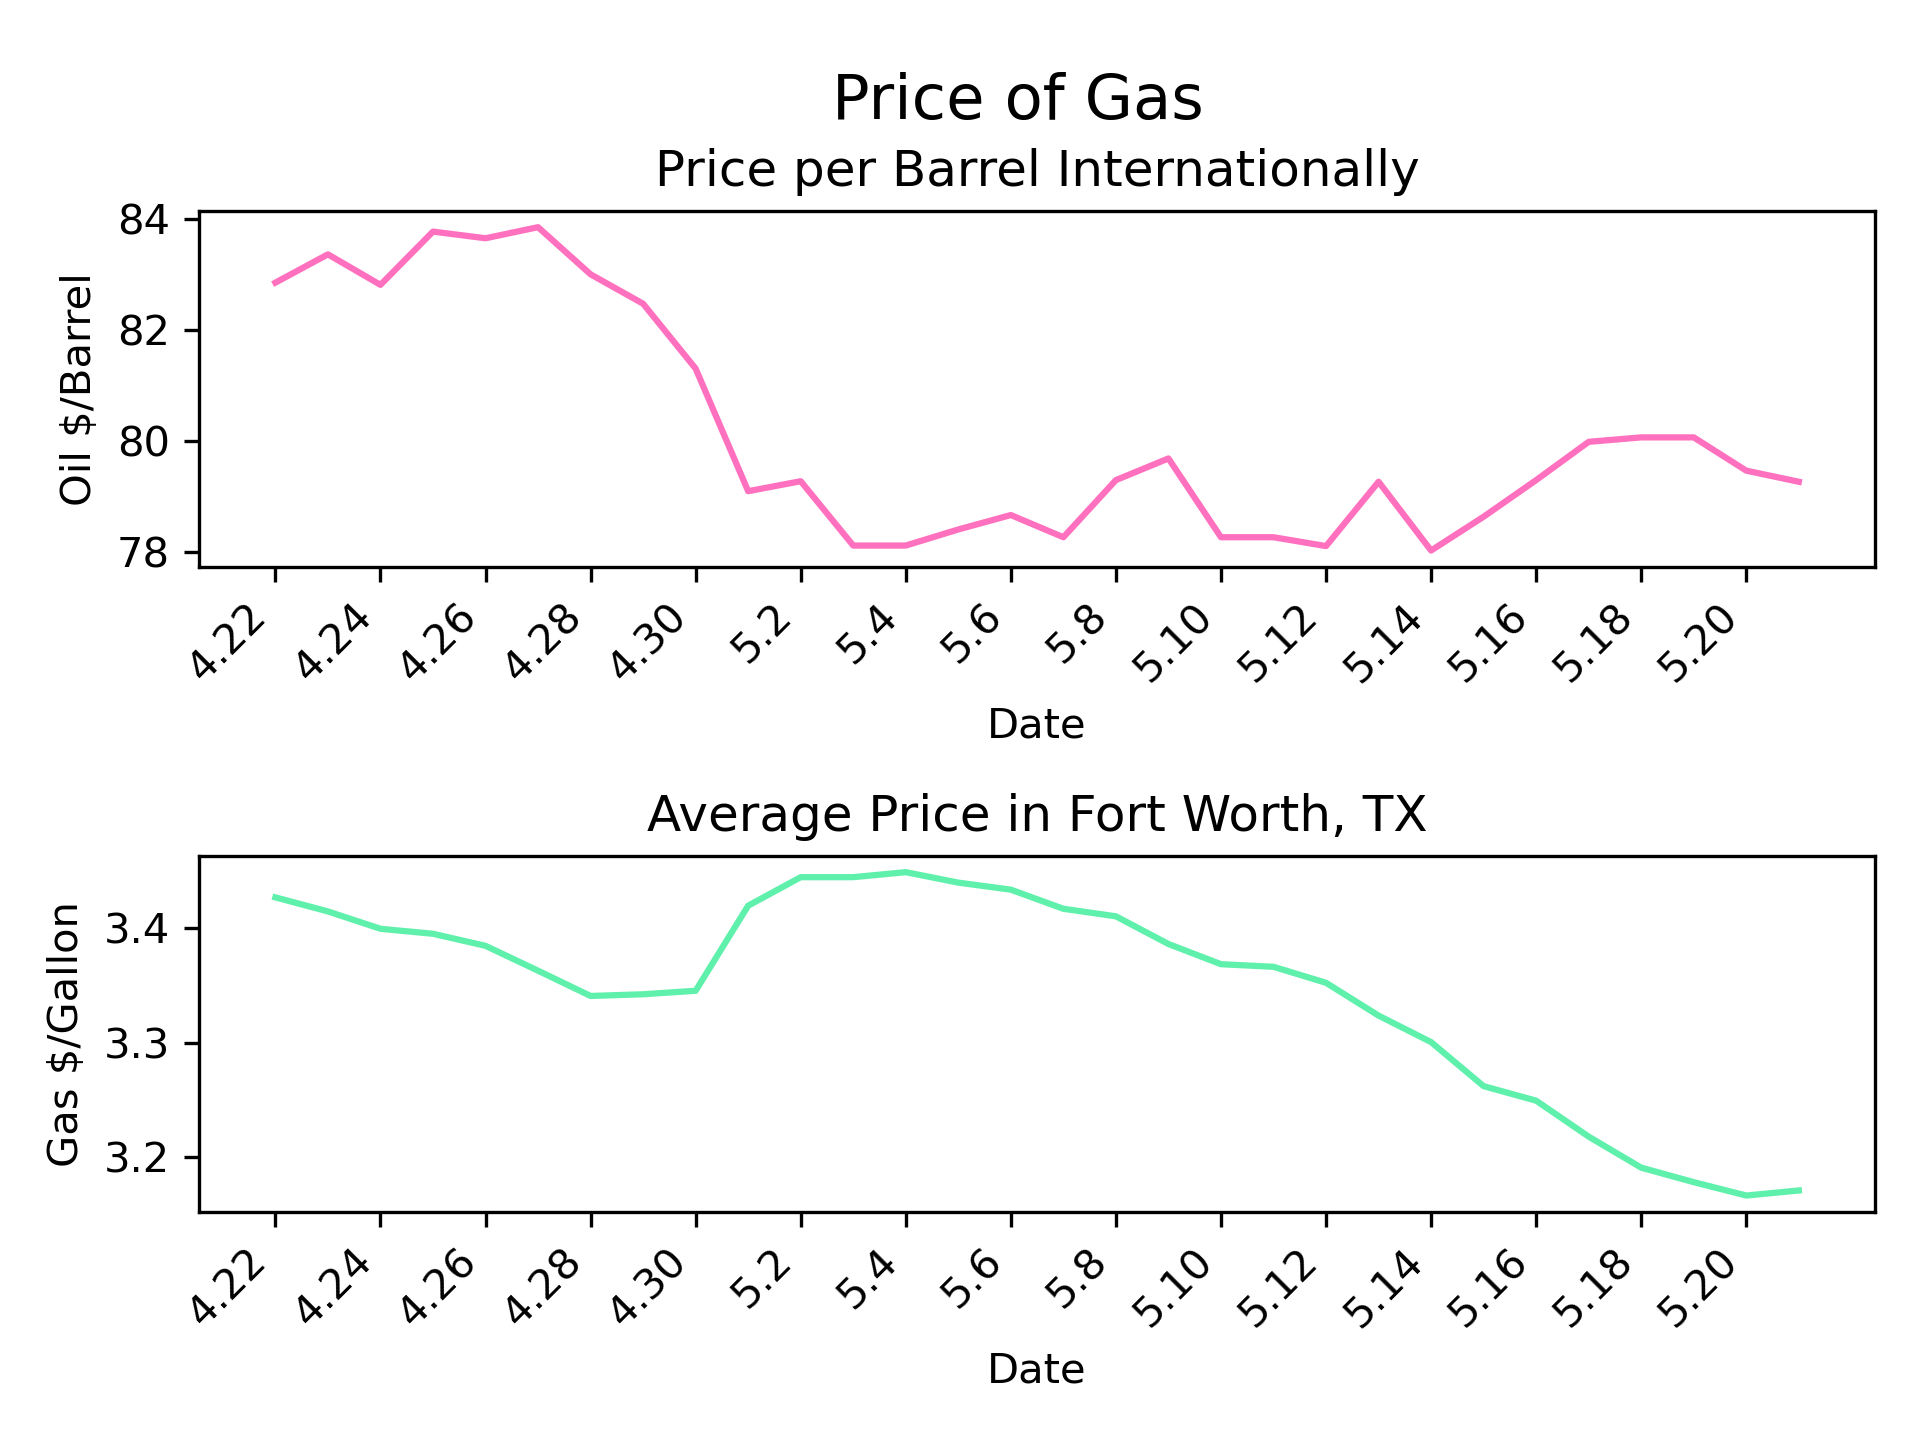

In [ ]:
## Creating a map of the stations and their prices
#----------------------------------------------------#

# Making a new dataframe with only the most recent day's observations
heatmap_df = df3[-100:] # customizable range to select desired date

sns.set(font_scale=1)
plt.figure(figsize=(8,5))

# Cleaning the dataframe to make it intelligible for seaborn's heatmap function
heatmap_df = heatmap_df.round(5)
hm = heatmap_df.pivot(index = 'lat',columns = 'long',values = 'price')
hm = hm.iloc[::-1] # reverses the order of the observations
                        # I needed to mirror the map vertically because the
                        # latitudes were counting in the wrong direction.
                        # The longitudes, however, were in the correct order

# Applying options to the figure (colors, labels, and title)
heatmap = sns.heatmap(hm, cmap = sns.color_palette(palette = "RdPu"), robust= True)
heatmap.set_xlabel('Longitude')
heatmap.set_ylabel('Latitude')
heatmap.set_title('Prices In "Area", "Date"', fontsize = 16)

plt.savefig('heatmap.png', dpi = 300, transparent=False, bbox_inches = 'tight')

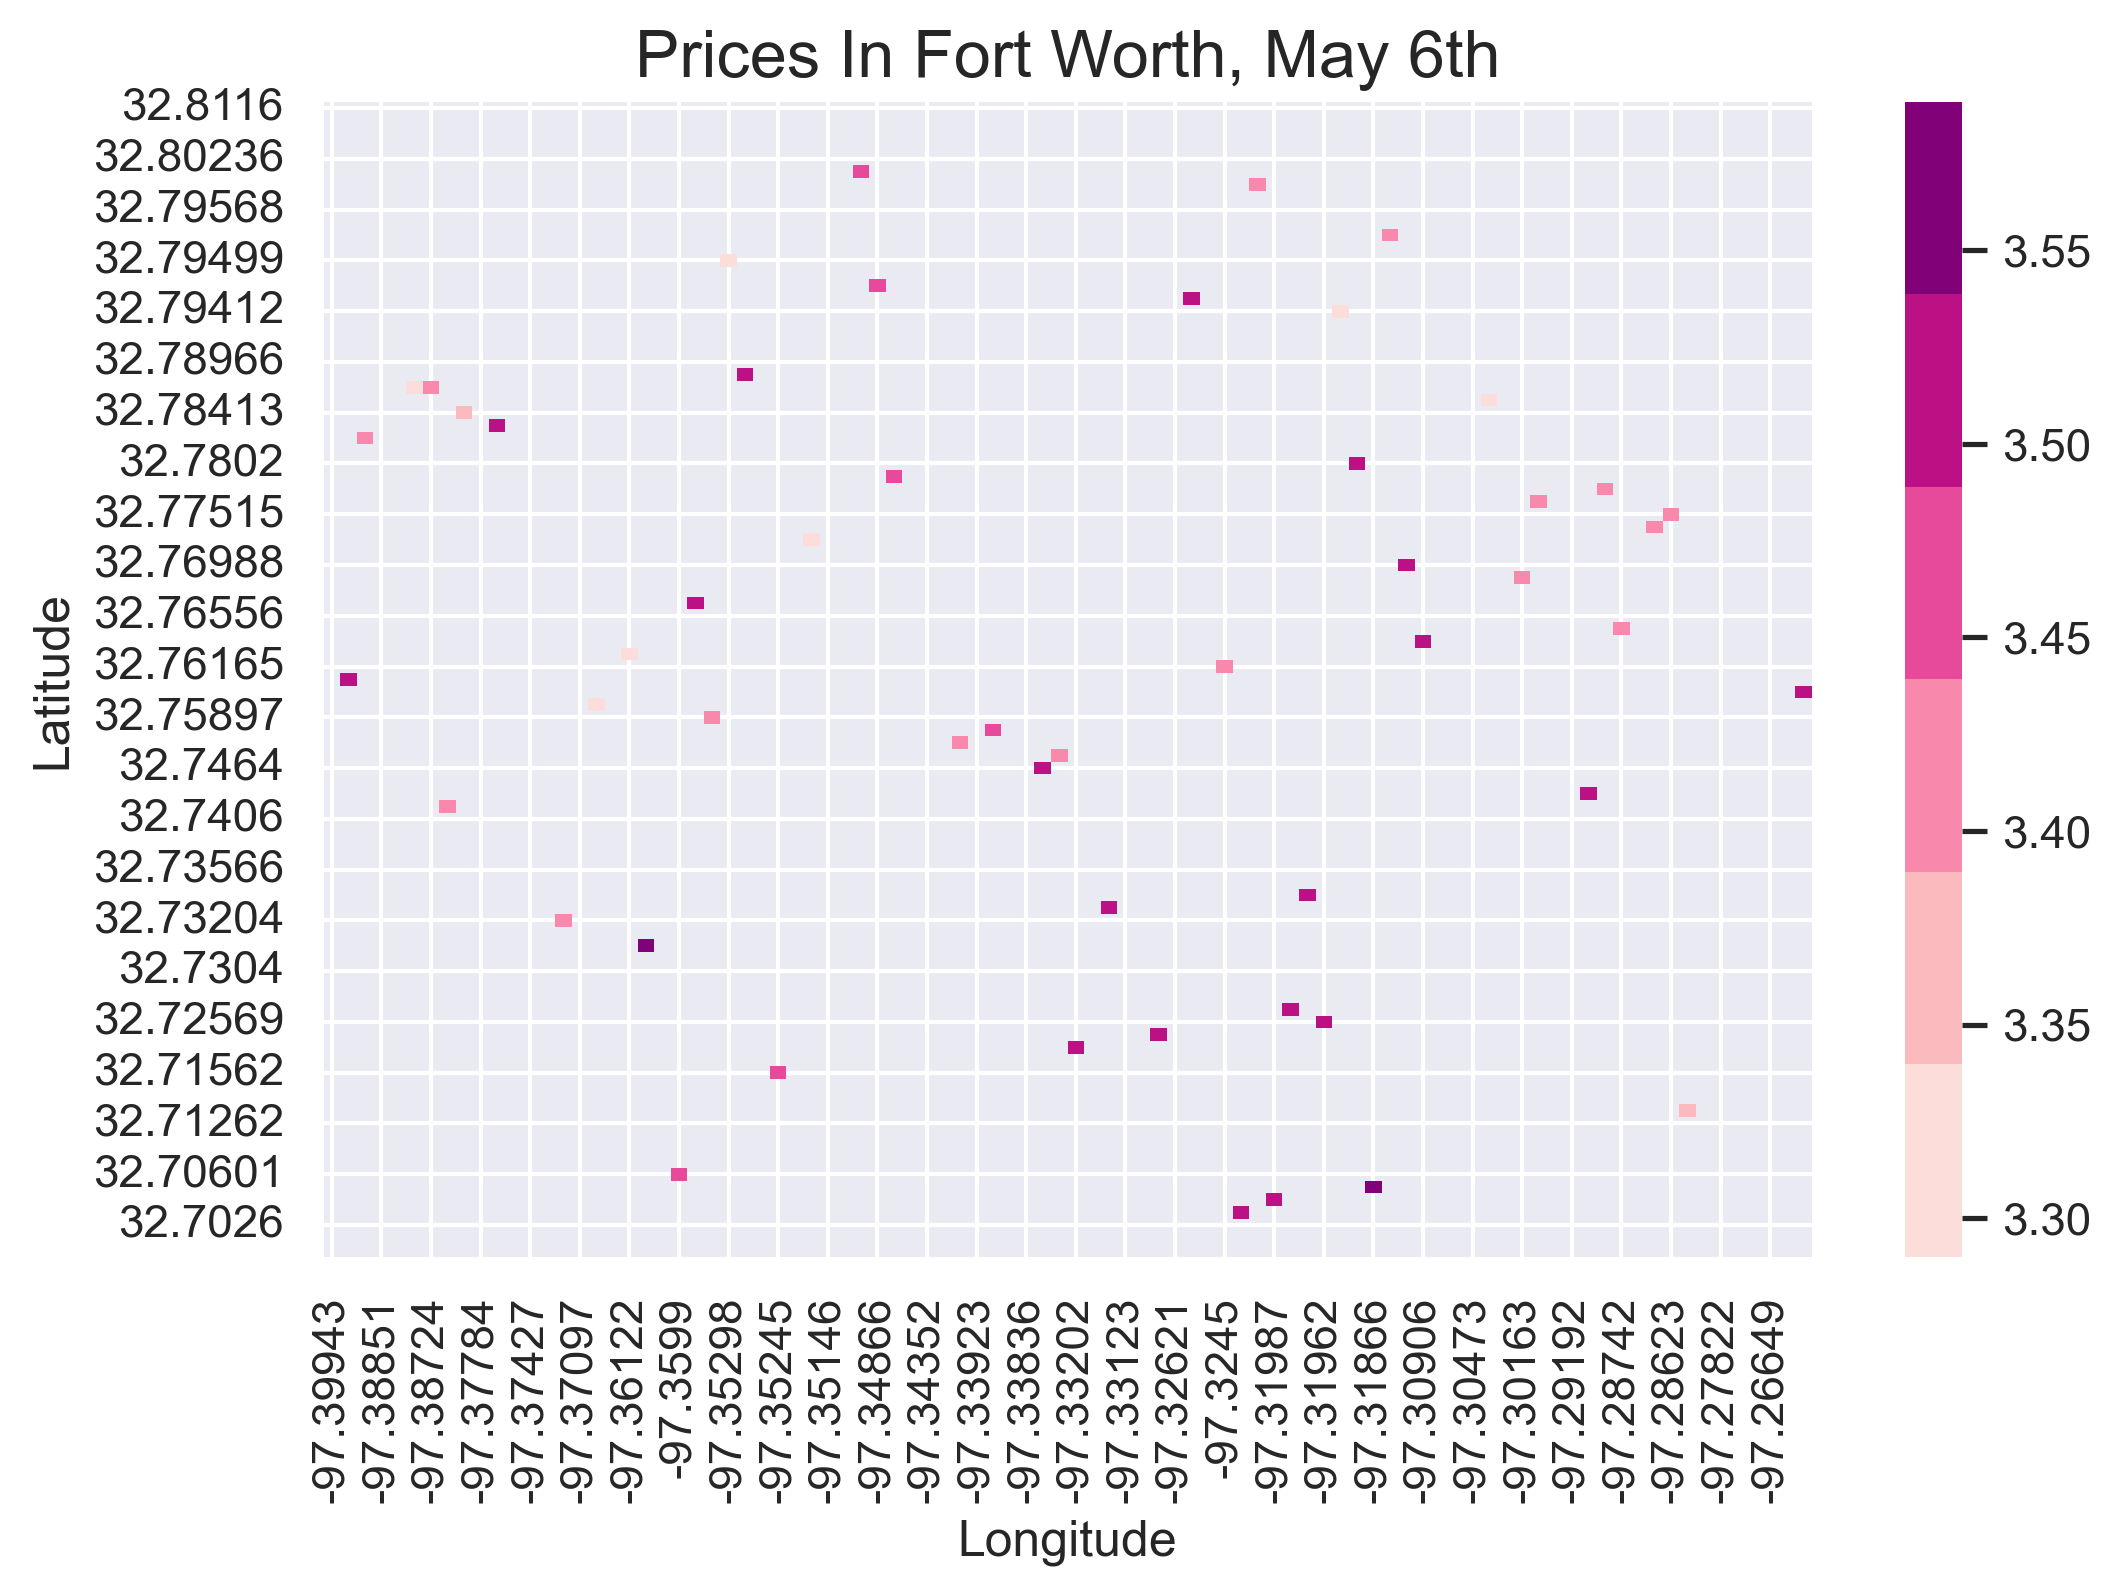